This is the second in a series of posts in which I explore concepts in Andrew Ng's [Introduction to Machine Learning](https://www.coursera.org/learn/machine-learning) course on Coursera.  As with the previous post on [linear regression](https://crsmithdev.com/blog/ml-linear-regression/), I'll implement the algorithm of the week in Python, first using standard Python data science and numerical libraries, and then conclude by building it in [Tensorflow](https://www.tensorflow.org/).

The topic of the week is [logistic regression](link).  Logistic regression looks and behaves similarly to [linear regression](link self), but instead of predicting a continuous output, classifies training examples into one of a distinct set of categories or labels.  For example, linear regression on a set of social and economic data might be used to predict a person's income, but logistic regression could be used to predict whether that person was married, had children, or had ever been arrested.  In a basic sense, logistic regression only answers questions that have yes / no answers, or questions that can be answered with `0` or `1`.  However, it can easily be [extended](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to problems where there are a larger set of categories.

The data set here is the [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from UCI. It maps thirteen continuous variables representing chemical contents of a wine to three labels, each a different winery in Italy.

# Loading and Plotting Data
 
We begin by loading the data.  Initially, we'll only use two of the features from the data set: alcohol and ash.  For the labels, note the use of `label_binarize`.  This function takes a list of length $n$ with $m$ labels and returns an $n$ by $m$ matrix, consisting of only 1s and zeros, with column $m$ representing label $m$ as `1`, and all others as `0`.  This transforms one problem with three answers into three problems with two answers each, which will be helpful later.  At first though, I'm only using the first column, so `1` represents the first winery, and `0` represents the other two.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

X = data.as_matrix(columns=['alcohol', 'ash'])
y = data['class'].values
y = label_binarize(data['class'], [1, 2, 3])[:,0]

Unlike last time, we'll split the data into training and testing sets.  This is important, because using the classifier practically means feeding it data it *hasn't* seen yet.  To do this, I use `train_test_split` function from scikit-learn, selecting a random 20% sample of the data and removing it from the training set.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('train:', len(X_train), 'test:', len(X_test))

train: 142 test: 36


Because I'm going to show a lot of plots, I define a function that takes an $n$ by 2 set of data points `xy` and plots them, using $n$ by 1 list `labels` to vary the symbol and color for each point.  This function supports up to three label values, sufficient for this data set.

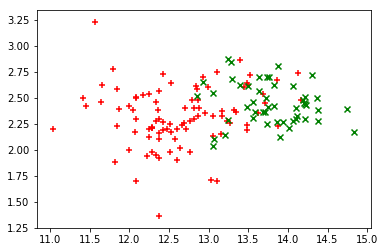

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

There's clearly a good place for a line to divide the two sets of points above, with a small amount of error, so this is well-suited for a first attempt at logistic regression.

# Simple Logistic Regression

An implementation of logistic regression requires three things: a hypothesis function $h_\theta$, a cost function $J(\theta)$, and an algorithm to minimize the value of $J(\theta)$ using its gradient, or partial derivative.

The hypothesis function $h_\theta$ in logistic regression is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  Conveniently, this function is bounded between 0 and 1, producing a probability value that can easily be interpreted as a yes / no answer:

\begin{align}
h_\theta(x) & = g(\theta^Tx) \\
g(z) & = \frac{1}{1 + e^{-z}}
\end{align}

It might seem tempting to just use [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) again, but with the sigmoid function as $h_\theta$, that would result in a cost function that [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html), meaning gradient descent wouldn't be guaranteed to find a global minimum.  Instead, we want a cost function that works differently for cases 0 and 1, and it's possible to rearrange the resulting multi-case function into a single function that's much easier to express computationally:

\begin{align}
Cost(h_\theta(x), y) & = \left\{\begin{array}{cr}
        -log(h_\theta(x)) & \text{if } y = 1 \\
        -log(1 - h_\theta(X)) & \text{if } y = 0 \\
        \end{array}\right\} \\
J(\theta) & =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
\end{align}

Fortunately, the derivative of this function is exactly the same as that of linear regression, just with a different $h_\theta$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [4]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    y = np.asmatrix(y).T
    theta = np.asmatrix(theta).T
    
    h = sigmoid(X * theta)
    pos = np.multiply(-y, np.log(h))
    neg = np.multiply((1 - y), np.log(1 - h))
    j = np.sum(pos - neg) / (len(X))
    
    return j

def gradient(theta, X, y):
    theta = np.asmatrix(theta).T
    y = np.asmatrix(y).T
    
    error = sigmoid(X * theta) - y
    grad = X.T * error / len(X)
    
    return grad

In the functions `cost` and `gradient` above, I convert the `y` and `theta` values, which are input as numpy `ndarray`s, to numpy matrices.  In the course of working on this post, I found that converting to matrices was better for implementing the algorithims, as matrices follow stricter linear algebra rules and make the language more Octave/MATLAB-like and
have other useful features.  Because the optimization algorithm used below prefers calls cost and gradient functions with arrays as $\theta$ parameters, it's necessary to convert.  Fortunately, `numpy.asmatrix` doesn't copy any data, and small costs of converting the interface are less important here.

To actually perform the gradient descent, I'm using a built-in algorithm from scipy called `fmin_tnc`, which performs the update step and `gradient` to find the global minimum of `cost`.  Note that right before running the optimizer, I prepend a column of 1s to the training data to add a constant bias parameter $\theta_0$.

In [5]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    result = fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X, y))
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [-47.37458594   3.40099898   0.66930085]


# Decision Boundaries and Evaluation

Its possible to evaluate the results of the optimization visually and statistically.  But before doing either, we need a prediction function that actually returns a 1 or 0 value for a new piece of data with the optimized $\theta$ values.  To do so, I once again prepend 1s, and then just return the integer value of whether the result of $h_\theta$ is above or below 0.5, the decision boundary.

Scikit-learn provides three functions to calculate accuracy, [precision](https://en.wikipedia.org/wiki/Precision_and_recall), and [recall](https://en.wikipedia.org/wiki/Precision_and_recall), giving us a look at the performance of the classifier against unseen test data.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return sigmoid(X * np.matrix(theta).T) >= 0.5

predictions = predict(X_test, theta)

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.694444444444
precision: 0.627272727273
recall: 0.634615384615


[???]

It's much more interesting to see the results visually, at least while we can with only two features.  To plot the decision boundary visually, we need to draw lines on the plot where the sigmoid function $h_\theta$ is approaches 0.5.  This can be accomplished using contour plots.

Below, we define a `plot_boundary` function that takes an $n$ by 2 matrix of values and a prediction function, and builds a mesh grid of x and y points from the range of that input data.  After unwinding it into a data set that works with the prediction function above, it gets the sigmoid value for each point in 2d space, then plots a contour line for those approaching 0.5.

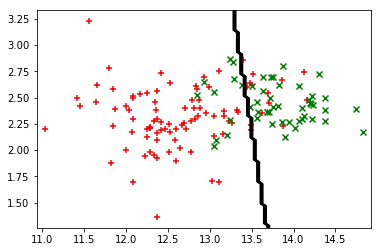

In [7]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
        
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))

It seems sensible, near somewhere I might draw a line if I were estimating it by hand.  But how does it look agains the test data?

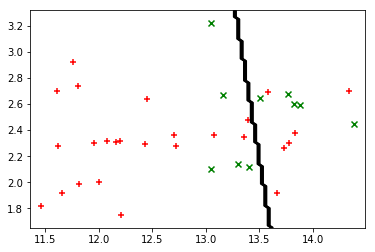

In [8]:
plot_boundary(X_test, lambda x: predict(x, theta))
plot_points(X_test, y_test)

[???]

Now for something more interesting: a similar set of data from the data set (alcohol and flavanoids), but now with all three classes instead of two.  The most straightforward 

together instead of 1 versus 2. The most straightforward way to do this is to use all columns from the `label_binarize` function, and 

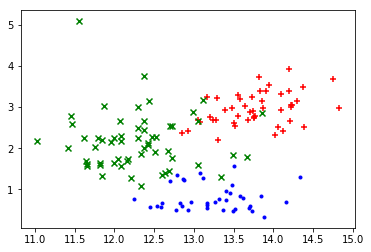

In [9]:
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = label_binarize(y_train, [1, 2, 3])

plot_points(X_train, y_train.argmax(axis=1))

/Users/csmith/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/Users/csmith/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply


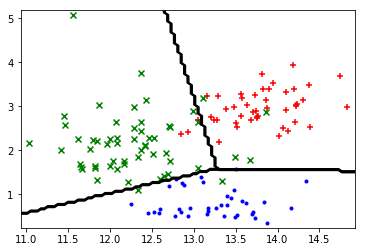

In [10]:
def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    result = fmin_tnc(func=cost, x0=np.zeros(3), fprime=gradient, args=(X, y))
    return np.matrix(result[0])

def predict_multilabel(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multilabel(x, thetas))

In [11]:
predictions = predict_multilabel(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.888888888889
precision: 0.895299145299
recall: 0.900793650794


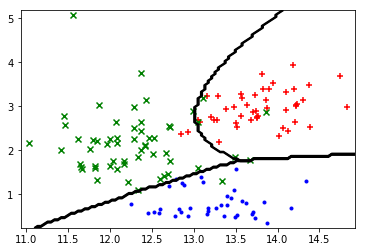

In [12]:
def transform(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1]]

def train(X, y):
    
    X = np.insert(X, 0, np.ones(len(X)), axis=1)

    #print(X)
    result = fmin_tnc(func=cost, x0=np.zeros(6), fprime=gradient, args=(X, y))
    return np.matrix(result[0])

def xplot(X):
    return np.apply_along_axis(transform, 1, X)

X_train_m = np.apply_along_axis(transform, 1, X_train)
thetas = [train(X_train_m, y_train[:,i]) for i in range(0,3)]

plot_points(X_train_m, y_train.argmax(axis=1))
plot_boundary(X_train_m, lambda x: predict_multilabel(xplot(x), thetas))

In [13]:
predictions = predict_multilabel(xplot(X_test), thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.861111111111
precision: 0.871794871795
recall: 0.873015873016


In [17]:
X = data.drop('class', 1).as_matrix()
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = label_binarize(y_train, [1, 2, 3])

def cost_reg(theta, X, y, l):
    return cost(theta, X, y) + np.square(theta).sum() / (2 * len(X))

def gradient2(theta, X, y, l):
    return gradient(theta, X, y) + np.matrix(theta).T / len(X)

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return fmin_tnc(func=cost_reg, x0=np.zeros(14), fprime=gradient2, args=(X, y, 1.0))[0]

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multilabel(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

TypeError: 'Tensor' object is not callable

In [15]:
#def plot_boundary(X, fn):
    
#    x_min, x_max = X[:,0].min(), X[:,0].max()
#    y_min, y_max = X[:,1].min(), X[:,1].max()
#    xx, yy = np.meshgrid(
#        np.linspace(x_min, x_max, 100),
#        np.linspace(y_min, y_max, 100)
#    )

#    inputs = np.c_[xx.ravel(), yy.ravel()]
#    inputs = np.apply_along_axis(transform_data, 1, inputs)
    
#    predictions = fn(inputs)
#    predictions = predictions.argmax(axis=1).reshape(xx.shape)

#    plt.contour(xx, yy, predictions, colors='black')

def transform_data(x):
    return x
    #return [x[0], x[1], x[0] ** 2, x[1] ** 2]

data = pd.read_csv('data.txt')
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
#XX = data.drop('class', 1).as_matrix()
#y = np.array([i - 1 for i in data['class']])


X = np.apply_along_axis(transform_data, 1, X)
y = label_binarize(data['class'], [1, 2, 3])
#print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('train:', len(X_train), 'test:', len(X_test))

train: 142 test: 36


weights: [[ 15.25718975 -22.14756203   6.88936043]
 [ 22.54719162   6.85621262 -29.3996582 ]]
bias: [-236.09155273  276.6081543   -40.51403809]
cost: 1.35491
predict: [2 1 1 1 0 2 2 0 2 0 0 1 2 2 0 0 1 2 2 1 2 2 1 0 2 2 0 2 2 1 0 0 2 2 2 1]
accuracy: 0.888888888889
precision: 0.894117647059
recall: 0.897435897436
[1 1 1 ..., 0 0 0]


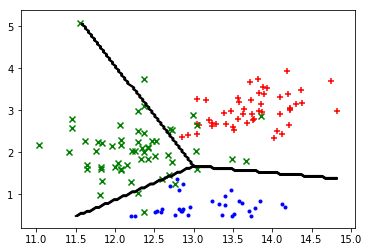

In [16]:
import tensorflow as tf

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min(), X[:,0].max()
    y_min, y_max = X[:,1].min(), X[:,1].max()
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    print(pred(xys))
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')

n_features = X_train.shape[1]
n_labels = y_train.shape[1]

examples = tf.placeholder(tf.float32, [None, n_features], name='examples')
y = tf.placeholder(tf.int32, [None, n_labels], name='y')

weights = tf.Variable(tf.zeros([n_features, n_labels]), name='weights')
bias = tf.Variable(tf.zeros([n_labels]), name='bias')

logits = tf.matmul(examples, weights) + bias
predict = tf.nn.softmax(logits)
reg = tf.nn.l2_loss(weights)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
opti = tf.train.GradientDescentOptimizer(1).minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for i in range(120000):
        sess.run(opti, feed_dict={examples: X_train, y: y_train})
        
    print('weights:', sess.run(weights))
    print('bias:', sess.run(bias))

    p = sess.run(predict, feed_dict={examples: X_test}).argmax(axis=1)
    c = sess.run(cost, feed_dict={examples: X_train, y: y_train})
    print('cost:', c)
    print('predict:', p)
    print('accuracy:', accuracy_score(y_test.argmax(axis=1), p))
    print('precision:', precision_score(y_test.argmax(axis=1), p, average='macro'))
    print('recall:', recall_score(y_test.argmax(axis=1), p, average='macro'))
    
    def pred(inputs):
        return sess.run(predict, feed_dict={examples: inputs})
    
    plt.show()
    plot_boundary(X_train, lambda i: pred(i).argmax(axis=1))
    plot_points(X_train, y_train.argmax(axis=1))